In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
import pathlib

data_dir = pathlib.Path('data')
print(f"Corrected data directory: {data_dir}")

if data_dir.exists():
    print("Directory exists")
else:
    print("Directory does not exist")

all_files = list(data_dir.glob('**/*'))
print(f"Total files found: {len(all_files)}")

print("First few files:")
for file in all_files[:5]:
    print(file)

image_files = list(data_dir.glob('**/*.png'))
image_count = len(image_files)
print(f"Total image files found: {image_count}")

Corrected data directory: data
Directory exists
Total files found: 430
First few files:
data\horse
data\unicorn
data\horse\01_001.png
data\horse\01_002.png
data\horse\01_003.png
Total image files found: 428


In [3]:
image_files = list(data_dir.glob('*/*.png'))
image_count = len(image_files)
print(image_count)

428


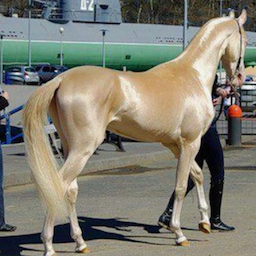

In [4]:
horses = list(data_dir.glob('horse/*'))
PIL.Image.open(str(horses[0]))

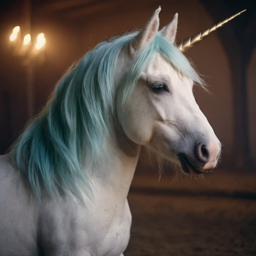

In [5]:
unicorns = list(data_dir.glob('unicorn/*'))
PIL.Image.open(str(unicorns[0]))

In [6]:
batch_size = 16
img_height = 256
img_width = 256

In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 428 files belonging to 2 classes.
Using 343 files for training.
Found 428 files belonging to 2 classes.
Using 85 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['horse', 'unicorn']


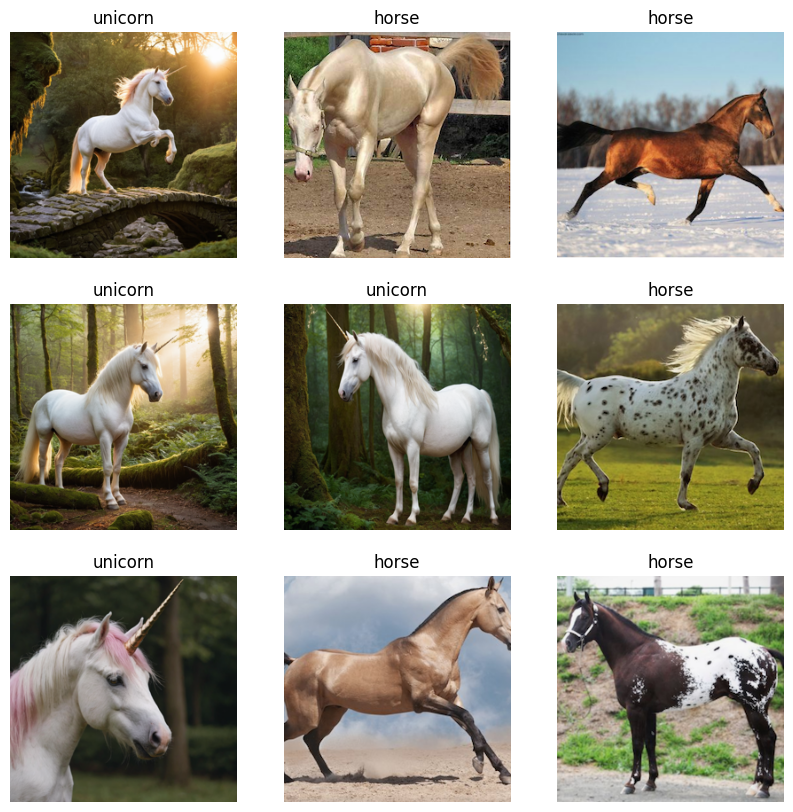

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
normalization_layer = layers.Rescaling(1. / 255)
num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1. / 255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

D:\MLDL\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,578 (32.09 MB)

 Trainable params: 8,412,578 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5539 - loss: 1.0977 - val_accuracy: 0.9176 - val_loss: 0.2360
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9397 - loss: 0.1896 - val_accuracy: 0.9412 - val_loss: 0.1260
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9692 - loss: 0.1102 - val_accuracy: 0.9412 - val_loss: 0.2212
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9758 - loss: 0.0776 - val_accuracy: 0.9765 - val_loss: 0.0974
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.9943 - loss: 0.0305 - val_accuracy: 0.9647 - val_loss: 0.0538
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 1.0000 - loss: 0.0078 - val_accuracy: 0.9647 - val_loss: 0.1009
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9765 - val_loss: 0.0441
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9647 - v

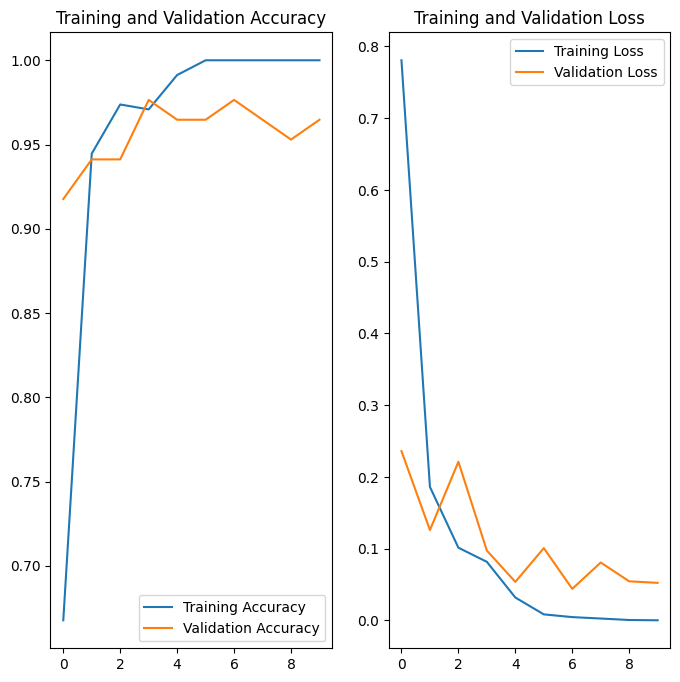

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [16]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


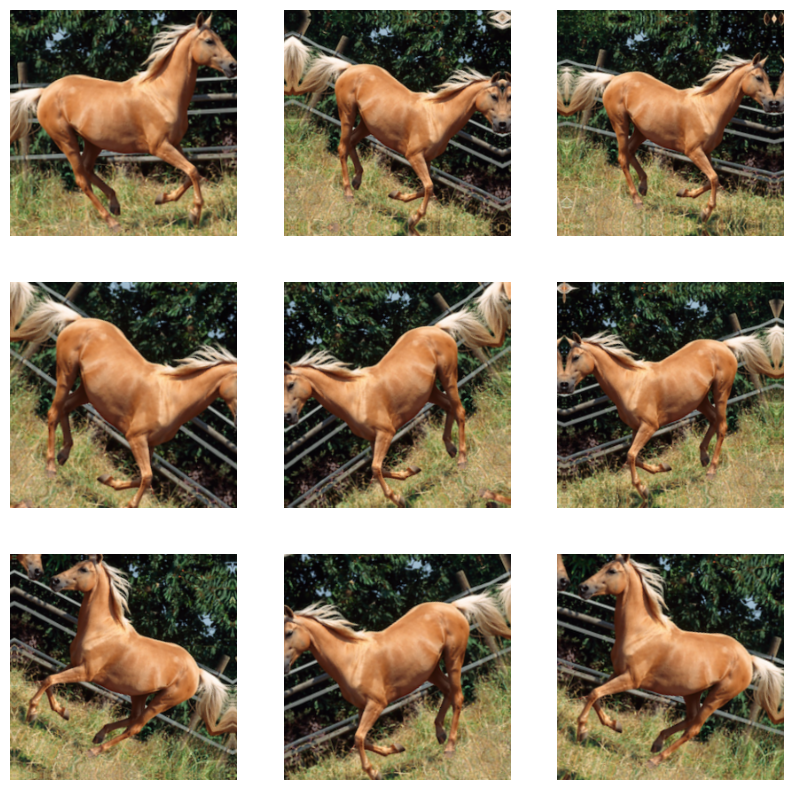

In [17]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [18]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [20]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,412,578 (32.09 MB)

 Trainable params: 8,412,578 (32.09 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.5503 - loss: 1.7720 - val_accuracy: 0.9176 - val_loss: 0.4307
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.8957 - loss: 0.3627 - val_accuracy: 0.9059 - val_loss: 0.1785
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9134 - loss: 0.2305 - val_accuracy: 0.8824 - val_loss: 0.2138
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9372 - loss: 0.1678 - val_accuracy: 0.9294 - val_loss: 0.1816
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9647 - loss: 0.1158 - val_accuracy: 0.9412 - val_loss: 0.1531
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9810 - loss: 0.0926 - val_accuracy: 0.9294 - val_loss: 0.1641
Epoch 7/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9624 - loss: 0.1117 - val_accuracy: 0.9412 - val_loss: 0.0849
Epoch 8/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9874 - loss: 0.0476 - val_accuracy: 0.9412 - v

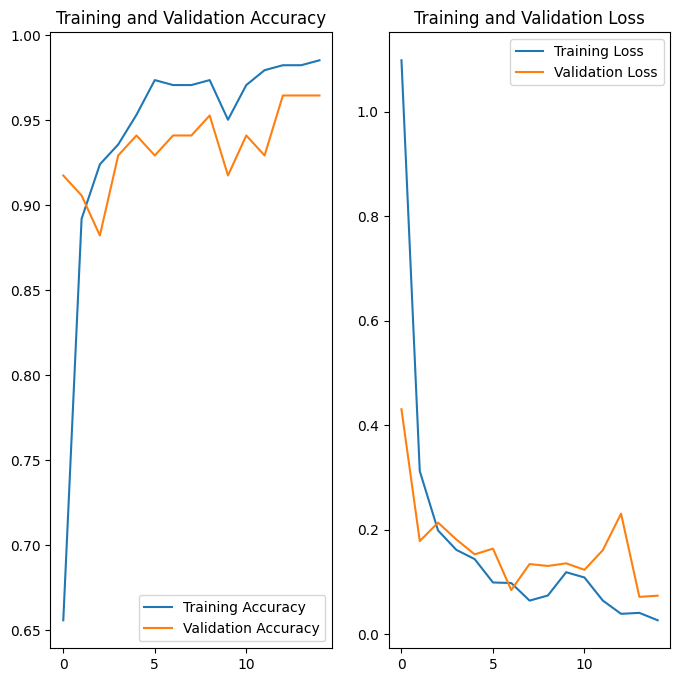

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# More augementation and more complex model

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
  ]
)

In [24]:
# Model with increased complexity and regularization
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5),
  layers.Dense(num_classes, name="outputs")
])

In [25]:
# Compile the model with a learning rate scheduler
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
# Train the model for more epochs
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 0.9765 - val_loss: 0.1051
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 168ms/step - accuracy: 1.0000 - loss: 0.0024 - val_accuracy: 0.9882 - val_loss: 0.1678
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9765 - val_loss: 0.1108
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 166ms/step - accuracy: 0.9984 - loss: 0.0049 - val_accuracy: 0.9765 - val_loss: 0.2263
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 170ms/step - accuracy: 0.9931 - loss: 0.0166 - val_accuracy: 0.9765 - val_loss: 0.1225
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 167ms/step - accuracy: 0.9820 - loss: 0.0416 - val_accuracy: 0.9765 - val_loss: 0.1491
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 169ms/step - accuracy: 0.9832 - loss: 0.0531 - val_accuracy: 0.9882 - val_loss: 0.0282
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.9939 - loss: 0.0155 - val_accuracy: 0.

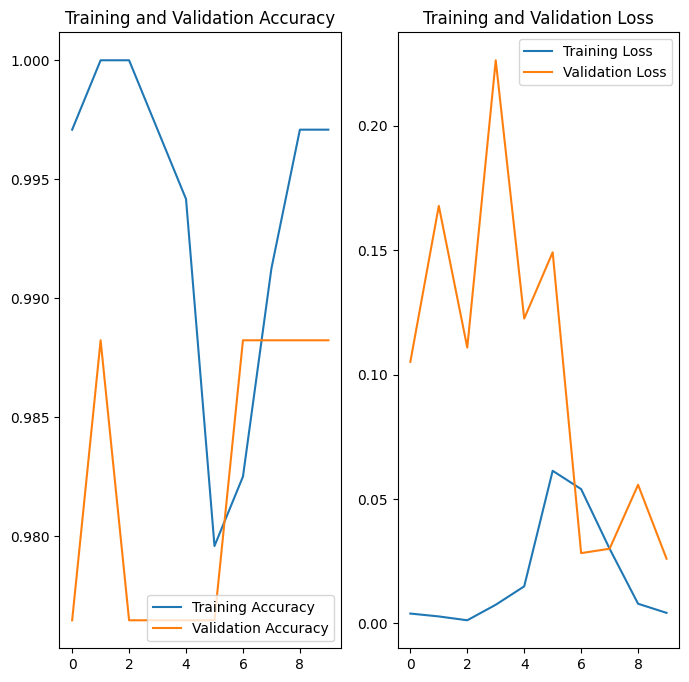

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
